## MIS780 - Advanced Artificial Intelligence for Business

## Week 8 - Part 1:  Genetic Algorithm in Business

In this session, you will be using a Genetic Algorithm to find a solution to the traveling salesman problem (TSP)

## Table of Content
   
1.  [Traveling Salesman Problem](#cell_TSP)


2.  [Building Genetic Algorithm](#cell_Build)
    - [Create two classes: City and Fitness](#cell_twoclasses)
    - [Create the population](#cell_population)
    - [Determine fitness](#cell_Determinefitness)
    - [Select the mating pool](#cell_matingpool)
    - [Crossover](#cell_crossover)
    - [Mutation](#cell_Mutatation)
    - [Repeat](#cell_Repeat)
    

3.  [Evolution in motion](#cell_motion)

<a id = "cell_TSP"></a>
### 1.  Traveling Salesman Problem (TSP)

The TSP is described as follows:

*_"Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?"_*

Given this, there are two important rules to keep in mind:
1. Each city needs to be visited exactly one time
2. We must return to the starting city, so our total distance needs to be calculated accordingly

**The approach**

Let’s start with a few definitions in the context of the TSP:

- **Gene**: a city (represented as (x, y) coordinates)
- **Individual (“chromosome”)**: a single route satisfying the conditions above
- **Population**: a collection of possible routes (i.e., collection of individuals)
- **Parents**: two routes that are combined to create a new route
- **Mating pool**: a collection of parents that are used to create our next population (thus creating the next generation of routes)
- **Fitness**: a function that tells us how good each route is (in our case, how short the distance is)
- **Mutation**: a way to introduce variation in our population by randomly swapping two cities in a route
- **Elitism**: a way to carry the best individuals into the next generation

Our GA will proceed in the following steps:
1. Create the population

2. Determine fitness

3. Select the mating pool

4. Crossover

5. Mutation

6. Repeat

<a id = "cell_Build"></a>
###  2. Building Genetic Algorithm

While each part of our GA is built from scratch, we’ll use a few standard packages to make things easier:

In [86]:
import numpy as np
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt

<a id = "cell_twoclasses"></a>
###  Create two classes: City and Fitness

We first create a `City` class that will allow us to create and handle our cities. These are simply our **(x, y)** coordinates. Within the City class, we add a `distance` calculation (making use of the Pythagorean theorem) and a clean way to output the cities as coordinates with `__repr__`.

In [87]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    #calculate distance betwen two cities
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

    #output the cities as coordinates
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

We’ll also create a `Fitness` class. In our case, we’ll treat the fitness as the **inverse of the route distance**. We want to minimize route distance, so a larger fitness score is better. Based on Rule 2 of the TSP, we need to start and end at the same place, so this extra calculation is accounted for in the distance calculation.

In [88]:
class Fitness:
    def __init__(self, route):
        self.route = route #An array of city IDs
        self.distance = 0
        self.fitness= 0.0

    #Calculate total distance of a route
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                #Find the index of the next city
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else: #In case the next city is the starting city
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance

    #fitness as the inverse of the route distance
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

<a id = "cell_population"></a>
###  Create the population

We now can make our **initial population** (first generation). To do so, we need a way to create a function that produces routes that satisfy our conditions. To create an individual, we randomly select the order in which we visit each city:

In [89]:
#Create an initial individual (route)
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

This produces one individual, but we want a full population, so let’s do that in our next function. This is as simple as looping through the createRoute function until we have as many routes as we want for our population.

In [90]:
#Create a population (multiple routes)
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

*_Note: we only have to use these functions to create the initial population. Subsequent generations will be produced through breeding and mutation._*

<a id = "cell_Determinefitness"></a>
###  Determine fitness

To simulate our “survival of the fittest”, we can make use of `Fitness` to rank each individual in the population. Our output will be an ordered list with the route IDs and each associated fitness score.

In [91]:
#Compute fitness for each route in population and sorted by fitness scores.
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

<a id = "cell_matingpool"></a>
### Select the mating pool

There are a few options for how to select the parents that will be used to create the next generation. The most common approaches are:
- **Roulette wheel selection**: The fitness of each individual relative to the population is used to assign a probability of selection. Think of this as the fitness-weighted probability of being selected.
- **Tournament selection**: A set number of individuals are randomly selected from the population and the one with the highest fitness in the group is chosen as the first parent. This is repeated to chose the second parent.

Another design feature to consider is the use of elitism. With **elitism**, the best performing individuals from the population will automatically carry over to the next generation, ensuring that the most successful individuals persist.

For the purpose of clarity, we’ll create the mating pool in two steps. First, we’ll use the output from `rankRoutes` to determine which routes to select in our `selection` function. We set up the roulette wheel by calculating a relative fitness weight for each individual. Then, we compare a randomly drawn number to these weights to select our mating pool. We’ll also want to hold on to our best routes, so we introduce elitism. Ultimately, the `selection` function returns a list of route IDs, which we can use to create the mating pool in the `matingPool` function.

In [92]:
#popRanke: list of ranked routes
#eliteSize: how many best routes to keep in elitism
def selection(popRanked, eliteSize):
    selectionResults = []
    #set up the roulette wheel
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()

    #elitism to keep the best routes
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])

    #compare a randomly drawn number to the weights to select mating pool
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Now that we have the IDs of the routes that will make up our mating pool from the `selection` function, we can create the mating pool. We’re simply extracting the selected individuals from our population.

In [93]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

<a id = "cell_crossover"></a>
###  Crossover

With our mating pool created, we can create the next generation in a process called crossover.  If our individuals were strings of 0s and 1s and our two rules didn’t apply (e.g., imagine we were deciding whether or not to include a stock in a portfolio), we could simply pick a crossover point and splice the two strings together to produce an offspring.

However, the TSP is unique in that we need to include all locations exactly one time. To abide by this rule, we can use a special crossover function called **ordered crossover**. In ordered crossover, we randomly select a subset of the first parent string and then fill the remainder of the route with the genes from the second parent in the order in which they appear, without duplicating any genes in the selected subset from the first parent.

In [94]:
def crossover(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []

    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))

    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    #randomly select a subset of the first parent string
    for i in range(startGene, endGene):
        childP1.append(parent1[i])

    #not duplicating any genes in the selected subset from the first parent
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Next, we’ll generalize this to create our offspring population.

In [95]:
def crossoverPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    #use elitism to retain the best routes from the current population
    for i in range(0,eliteSize):
        children.append(matingpool[i])

    #use the crossover function to fill out the rest of the next generation
    for i in range(0, length):
        child = crossover(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

<a id = "cell_Mutatation"></a>
###  Mutation

Mutation serves an important function in GA, as it helps to avoid local convergence by introducing novel routes that will allow us to explore other parts of the solution space. Similar to crossover, the TSP has a special consideration when it comes to mutation. Again, if we had a chromosome of 0s and 1s, mutation would simply mean assigning a low probability of a gene changing from 0 to 1, or vice versa (to continue the example from before, a stock that was included in the offspring portfolio is now excluded).

However, since we need to abide by our rules, we can’t drop cities. Instead, we’ll use swap mutation. This means that, with specified low probability, two cities will swap places in our route. We’ll do this for one individual in our `mutate` function:

In [96]:
#individual: Each Route
#mutationRate: specify how likely a gene is mutated
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))

            city1 = individual[swapped]
            city2 = individual[swapWith]

            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Next, we can extend the mutate function to run through the new population.

In [97]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []

    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

<a id = "cell_Repeat"></a>
###  Repeat

Let’s pull these pieces together to create a function that produces a new generation. First, we rank the routes in the current generation using `rankRoutes`. We then determine our potential parents by running the `selection` function, which allows us to create the mating pool using the `matingPool` function. Finally, we then create our new generation using the `crossoverPopulation` function and then applying mutation using the `mutatePopulation` function.

In [98]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = crossoverPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

<a id = "cell_motion"></a>
###  3. Evolution in motion

We finally have all the pieces in place to create our Genertic Algorithm. All we need to do is create the initial population, and then we can loop through as many generations as we desire. Of course we also want to see the best route and how much we’ve improved, so we capture the initial distance (remember, distance is the inverse of the fitness), the final distance, and the best route.

In [99]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))

    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        print("Best distance so far: " + str(1 / rankRoutes(pop)[0][1]))

    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

**Running the genetic algorithm**

With everything in place, solving the TSP is as easy as two steps:

First, we need a list of cities to travel between. For this demonstration, we’ll create a list of 20 random cities:

In [100]:
cityList = []
random.seed(2023)

for i in range(0,20):
    cityList.append(City(x=int(random.random() * 200),
                         y=int(random.random() * 200)))

Visualize the city loctaions

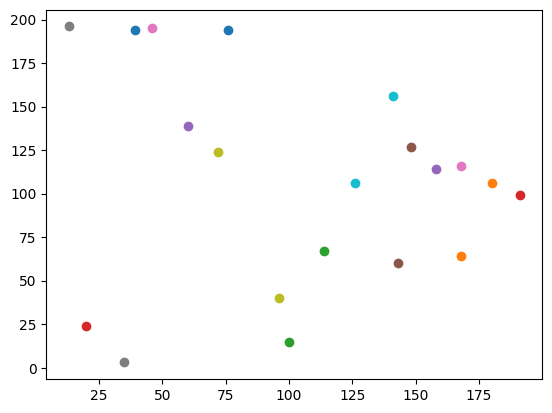

In [101]:
for City in cityList:
  plt.scatter(City.x, City.y)

Then, running the genetic algorithm is one simple line of code. This is where art meets science; you should see which assumptions work best for you. In this example, we have 50 individuals in each generation, keep 5 elite individuals, use a 1% mutation rate for a given gene, and run through 100 generations:

In [106]:
bestRoute = geneticAlgorithm(population=cityList,
                             popSize=50,
                             eliteSize=5,
                             mutationRate=0.01,
                             generations=500)

Initial distance: 1717.005387322016
Best distance so far: 1694.1920955291791
Best distance so far: 1658.4685569560972
Best distance so far: 1658.4685569560972
Best distance so far: 1658.4685569560972
Best distance so far: 1386.386422528773
Best distance so far: 1386.386422528773
Best distance so far: 1370.944144264921
Best distance so far: 1362.894750538003
Best distance so far: 1362.894750538003
Best distance so far: 1362.894750538003
Best distance so far: 1362.894750538003
Best distance so far: 1302.564072779952
Best distance so far: 1302.564072779952
Best distance so far: 1303.4971482200613
Best distance so far: 1342.88270417146
Best distance so far: 1324.161180267491
Best distance so far: 1324.161180267491
Best distance so far: 1247.5215225594347
Best distance so far: 1247.5215225594347
Best distance so far: 1241.0382318221891
Best distance so far: 1241.0382318221891
Best distance so far: 1236.4396620350478
Best distance so far: 1217.671098295512
Best distance so far: 1217.67109829

Visualize the best route

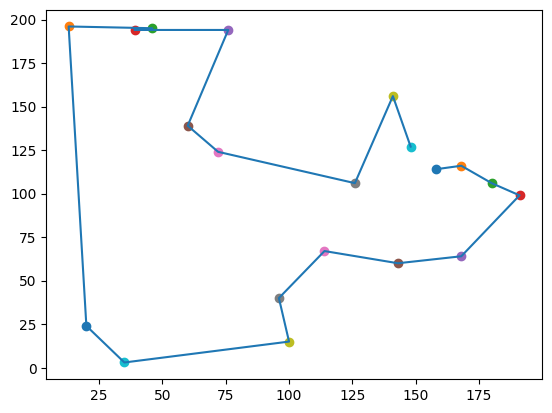

In [107]:
x_coordinate = [None] * 20
y_coordinate = [None] * 20
city_index = 0

for City in bestRoute:
  plt.scatter(City.x, City.y)
  x_coordinate[city_index] = City.x
  y_coordinate[city_index] = City.y
  city_index = city_index + 1

plt.plot(x_coordinate, y_coordinate, linestyle='-')

**Plot the improvement**

With a simple tweak to our `geneticAlgorithm` function, we can store the shortest distance from each generation in a progress list and then plot the results.

In [108]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])

    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])

    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

Run the Genertic Algorithm in the same way as before, but now using the newly created `geneticAlgorithmPlot` function:

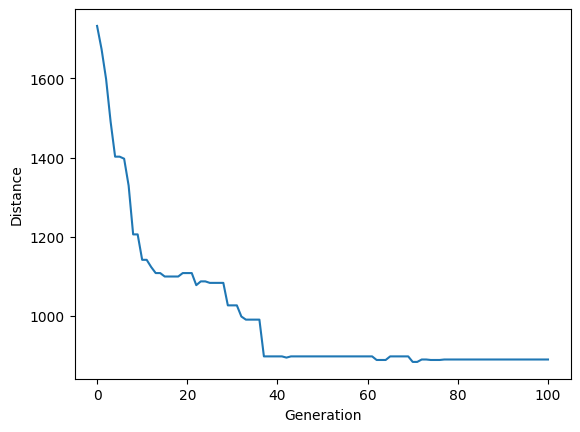

In [109]:
geneticAlgorithmPlot(population=cityList,
                 popSize=50,
                 eliteSize=5,
                 mutationRate=0.01,
                 generations=100)

### References:

- Stoltz, E. (2018). Evolution of a salesman: A complete genetic algorithm tutorial for Python. https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35